In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set() # для стилизации графиков
import numpy as np

### Знакомство с методом k-средних

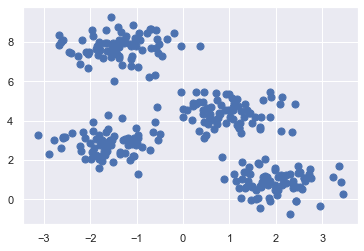

In [2]:
from sklearn.datasets import make_blobs

X, y_true = make_blobs(n_samples=300, centers=4, cluster_std=0.60, random_state=0)
plt.scatter(X[:, 0], X[:, 1], s=50);

In [3]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=4)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)

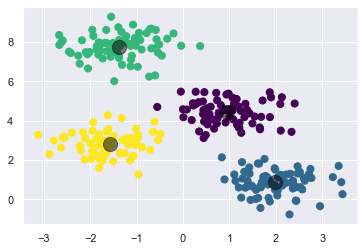

In [4]:
plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=50, cmap='viridis')
centers = kmeans.cluster_centers_ 
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)

### Алгоритм k-средних: максимизация математического ожидания

##### Алгоритм k-средних

In [8]:
from sklearn.metrics import pairwise_distances_argmin

def find_clusters(X, n_clusters, rseed=2):
	# 1. Выбираем кластеры случайным образом
	rng = np.random.RandomState(rseed)
	i = rng.permutation(X.shape[0])[:n_clusters]
	centers = X[i]
	while True:
		# 2a. Присваиваем метки в соответствии с ближайшим центром
		labels = pairwise_distances_argmin(X, centers)
		# 2b. Находим новые центры, исходя из средних значений точек
		new_centers = np.array([X[labels == i].mean(0) for i in range(n_clusters)])
		# 2c. Проверяем сходимость
		if np.all(centers == new_centers):
			break
		centers = new_centers
	
	return centers, labels

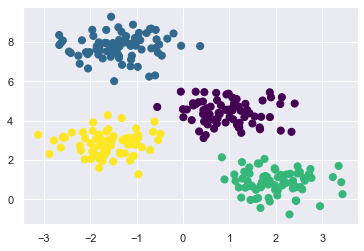

In [9]:
centers, labels = find_clusters(X, 4)
plt.scatter(X[:, 0], X[:, 1], c=labels, s=50, cmap='viridis');

Пример неудачной кластеризации при неудачной начальной инициализации центральных величин

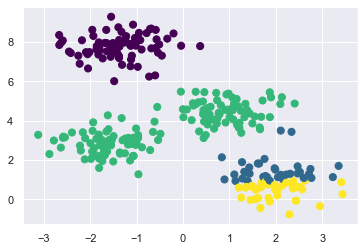

In [10]:
centers, labels = find_clusters(X, 4, rseed=0)
plt.scatter(X[:, 0], X[:, 1], c=labels, s=50, cmap='viridis');

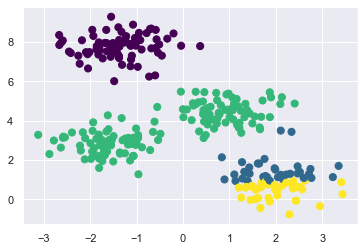

In [11]:
abels = KMeans(6, random_state=0).fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels, s=50, cmap='viridis')

### Пример неправильной работы Kmeans в случае нелинейных границ

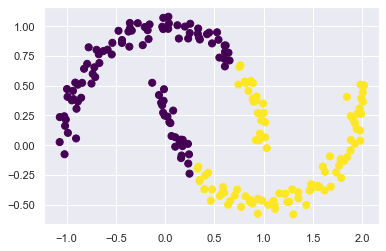

In [13]:
from sklearn.datasets import make_moons
X, y = make_moons(200, noise=.05, random_state=0)
labels = KMeans(2, random_state=0).fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels, s=50, cmap='viridis');

### SpectralClustering

d:\programming\volsu\semester_6\ai\volsu_ai\lib\site-packages\sklearn\manifold\_spectral_embedding.py:260: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


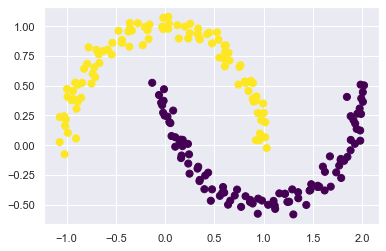

In [14]:
from sklearn.cluster import SpectralClustering
model = SpectralClustering(n_clusters=2, affinity='nearest_neighbors', assign_labels='kmeans')
labels = model.fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels, s=50, cmap='viridis');

### Пример 1: применение метода k-средних для рукописных цифр

In [15]:
from sklearn.datasets import load_digits
digits = load_digits()
digits.data.shape

(1797, 64)

In [16]:
kmeans = KMeans(n_clusters=10, random_state=0)
clusters = kmeans.fit_predict(digits.data)
kmeans.cluster_centers_.shape

(10, 64)

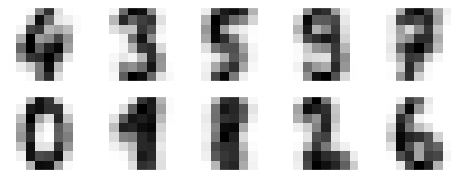

In [17]:
fig, ax = plt.subplots(2, 5, figsize=(8, 3))
centers = kmeans.cluster_centers_.reshape(10, 8, 8)

for axi, center in zip(ax.flat, centers):
	axi.set(xticks=[], yticks=[])
	axi.imshow(center, interpolation='nearest', cmap=plt.cm.binary)

In [18]:
from scipy.stats import mode
labels = np.zeros_like(clusters)

for i in range(10):
	mask = (clusters == i)
	labels[mask] = mode(digits.target[mask])[0]

In [19]:
from sklearn.metrics import accuracy_score
accuracy_score(digits.target, labels)

0.7935447968836951

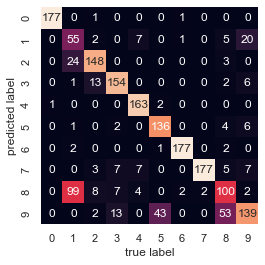

In [20]:
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(digits.target, labels)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, xticklabels=digits.target_names, yticklabels=digits.target_names)
plt.xlabel('true label')
plt.ylabel('predicted label');

### Алгоритм стохастического вложениясоседей на основе распределения Стьюдента (t-SNE)

In [21]:
from sklearn.manifold import TSNE
# Проекция данных: выполнение этого шага займет несколько секунд
tsne = TSNE(n_components=2, init='pca', random_state=0)
digits_proj = tsne.fit_transform(digits.data) # Расчет кластеров
kmeans = KMeans(n_clusters=10, random_state=0)
clusters = kmeans.fit_predict(digits_proj) # Перестановка меток местами
labels = np.zeros_like(clusters)

for i in range(10):
	mask = (clusters == i)
	labels[mask] = mode(digits.target[mask])[0]

accuracy_score(digits.target, labels)

d:\programming\volsu\semester_6\ai\volsu_ai\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
d:\programming\volsu\semester_6\ai\volsu_ai\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


0.9432387312186978

### Пример 2: использование метода k-средних для сжатия цветов

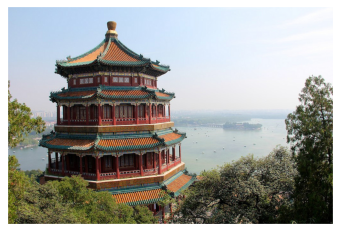

In [22]:
# Обратите внимание: для работы этого кода
# должен быть установлен пакет pillow
from sklearn.datasets import load_sample_image
china = load_sample_image("china.jpg")
ax = plt.axes(xticks=[], yticks=[])
ax.imshow(china);

In [23]:
china.shape

(427, 640, 3)

In [24]:
data = china / 255.0 # используем шкалу 0...1
data = data.reshape(427 * 640, 3)
data.shape

(273280, 3)

In [25]:
def plot_pixels(data, title, colors=None, N=10000):
	if colors is None:
		colors = data
		# Выбираем случайное подмножество
		rng = np.random.RandomState(0)
		i = rng.permutation(data.shape[0])[:N]
		colors = colors[i]
		R, G, B = data[i].T
		fig, ax = plt.subplots(1, 2, figsize=(16, 6))
		ax[0].scatter(R, G, color=colors, marker='.')
		ax[0].set(xlabel='Red', ylabel='Green', xlim=(0, 1), ylim=(0, 1))
		ax[1].scatter(R, B, color=colors, marker='.')
		ax[1].set(xlabel='Red', ylabel='Blue', xlim=(0, 1), ylim=(0, 1))
		fig.suptitle(title, size=20);

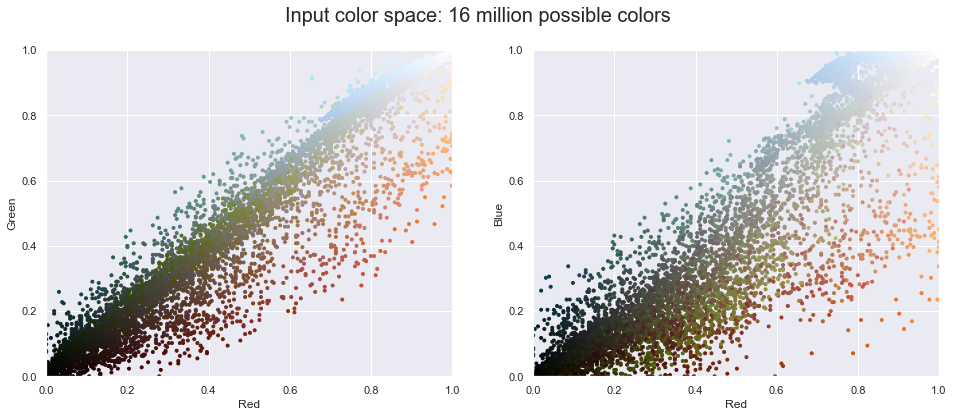

In [26]:
plot_pixels(data, title='Input color space: 16 million possible colors')

##### уменьшим количество цветов с 16 миллионов до 16 путемкластеризацииметодом k-средних на пространстве пикселов

In [28]:
from sklearn.cluster import MiniBatchKMeans
kmeans = MiniBatchKMeans(16)
kmeans.fit(data)
new_colors = kmeans.cluster_centers_[kmeans.predict(data)]
plot_pixels(data, colors=new_colors, title="Reduced color space: 16 colors")

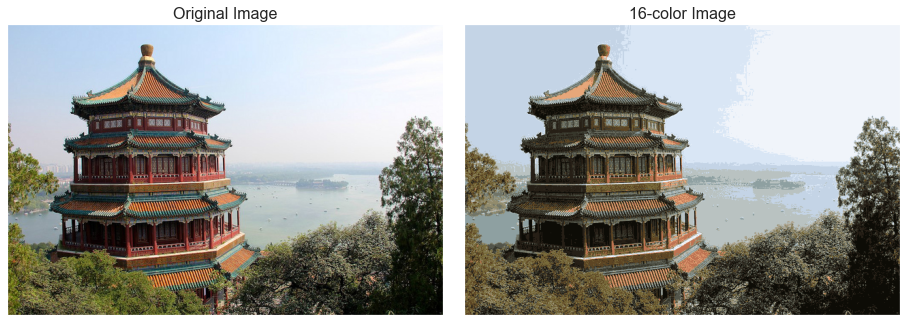

In [29]:
china_recolored = new_colors.reshape(china.shape)
fig, ax = plt.subplots(1, 2, figsize=(16, 6), subplot_kw=dict(xticks=[], yticks=[]))
fig.subplots_adjust(wspace=0.05)
ax[0].imshow(china)
ax[0].set_title('Original Image', size=16) # Первоначальное изображение
ax[1].imshow(china_recolored)
ax[1].set_title('16-color Image', size=16); # 16-цветное изображение